# eq_Taux_sea_cycle: Zonal structure of the amplitude of the mean seasonal cycle of Taux in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of of equatorial Pacific (150°E-90°W) amplitude (standard deviation) of the mean annual cycle (zonal 5°S-5°N average) zonal wind stress (Taux) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

## Datasets Used for Zonal Mean Stress Comparison

The following reference reanalysis datasets are used to evaluate the model simulations:

- **TropFlux (1979-2018)**: The primary dataset for comparison. TropFlux provides estimates of air-sea heat, momentum, and freshwater fluxes over the tropical oceans, designed specifically for tropical climate analysis by combining satellite data and in-situ measurements.

Additional reanalysis datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data based on surface pressure observations and historical data assimilation, offering a long-term record of climate and weather variability spanning over 140 years.
- **ERA-Interim (1979-2018)**: The European Centre for Medium-Range Weather Forecasts (ECMWF) reanalysis dataset delivers high-resolution atmospheric and surface variables using modern assimilation techniques, often used for climate and weather analysis.
- **NCEP2 (1979-2018)**: The second-generation reanalysis from the National Centers for Environmental Prediction (NCEP), offering improved global atmospheric and surface data by correcting known issues from the earlier version and assimilating more recent observations.

In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG

CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #tier3

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0012
--------------------------------------------------------------------------


In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tauu',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}



## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/tauu/gn/v20191115/tauu_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [7]:
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [8]:
def prepoc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

In [9]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


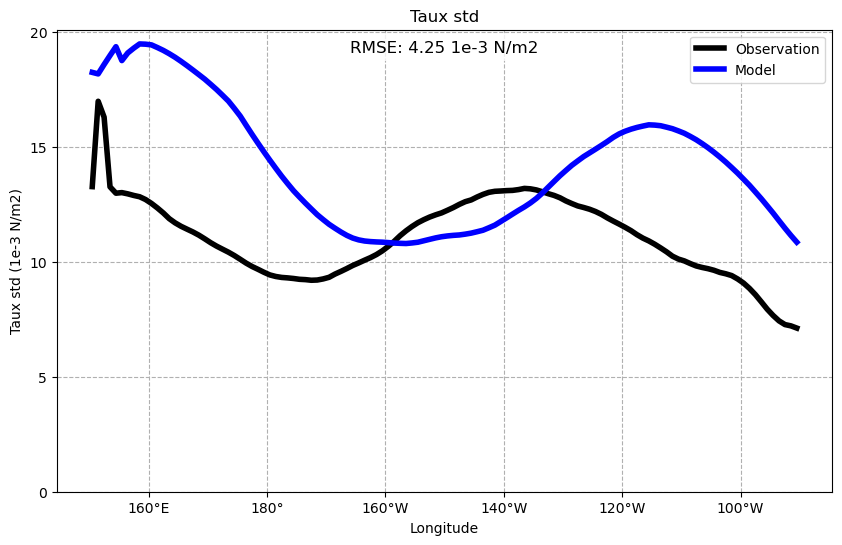

In [10]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["ERA-Interim"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Taux std (1e-3 N/m2)')
plt.title('Taux std')
plt.grid(linestyle='--')
plt.yticks(np.arange(0,21, step=5))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} 1e-3 N/m2', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the amplitude of the mean seasonal cycle of zonal wind stress (Taux) in the equatorial Pacific (averaged between 5°S–5°N). The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


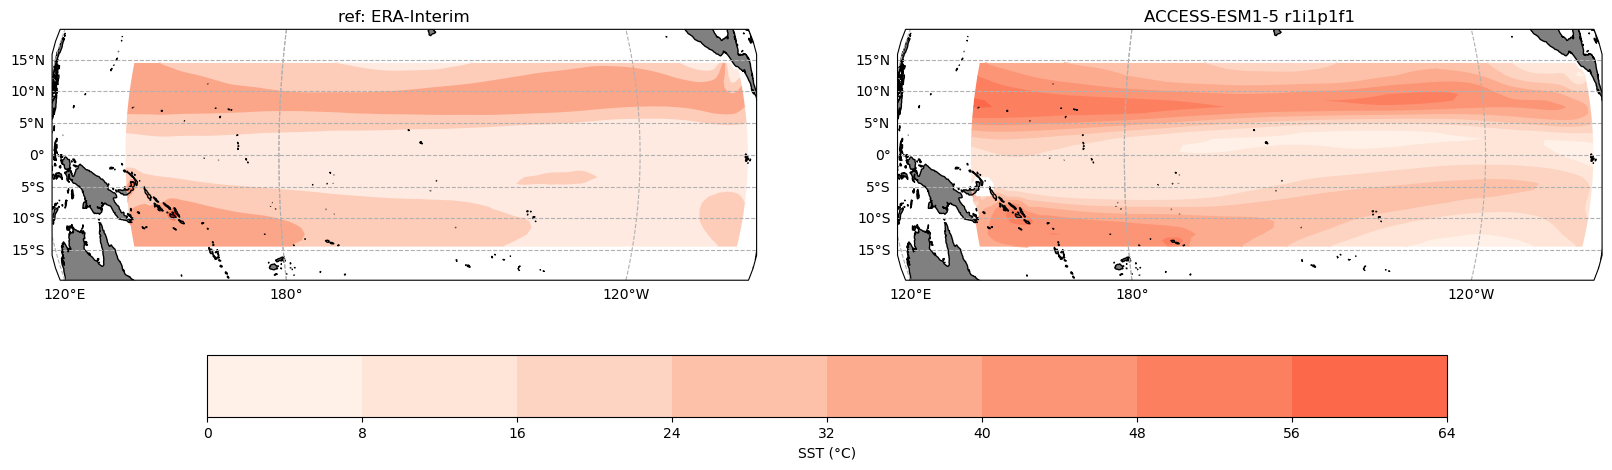

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["ERA-Interim"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('Reds')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of -100 to 100
norm = mcolors.Normalize()

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: ERA-Interim")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
# NOTE: The colorbar will be based on cf2, which already has the correct normalization applied.
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')
#cbar.set_clim(-100, 100)
#cbar.set_ticks(np.linspace(-100, 100, num=11))  # Set ticks ranging from -100 to 100

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Bias in the amplitude of the mean seasonal cycle of zonal wind stress (Taux) in the equatorial Pacific. The left map displays the reference data, while the right map shows the model data.

# Diagnostic Level 3

The third level shows the zonal structure of the mean seasonal cycle in a Hovmöller diagram

In [12]:

def preproc3(cube):
    eq_region = {"start_longitude": 160., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **eq_region)
    cube = axis_statistics(cube, axis="y", operator='mean')
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**model_datasets_prep3, **obs_datasets_prep3}

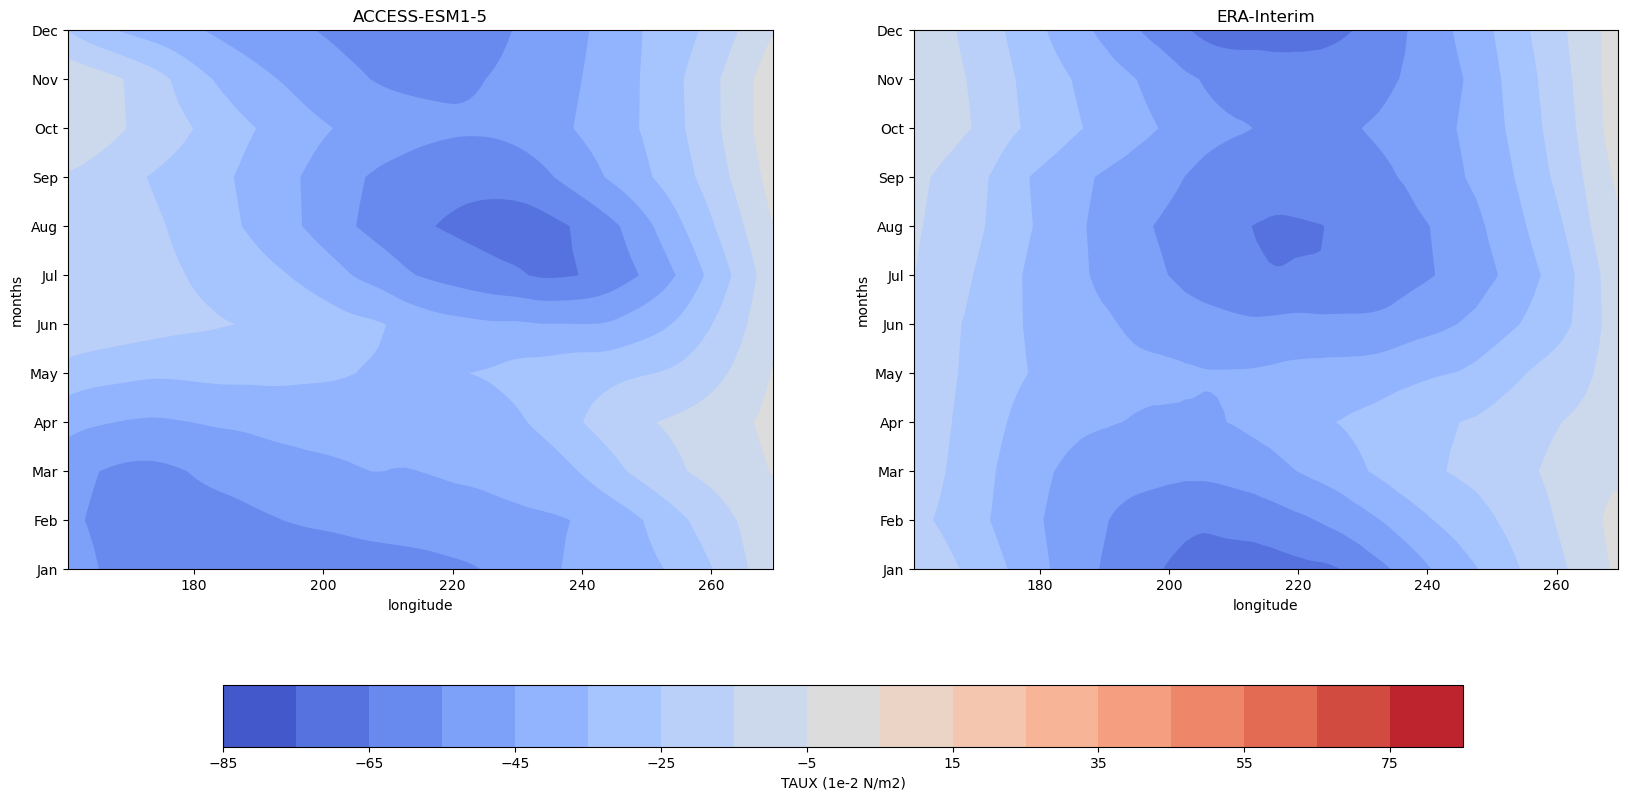

In [13]:
fig = plt.figure(figsize=(20, 10))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 1)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['longitude','month_number'],levels=np.arange(-85,95,10),cmap="coolwarm")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("longitude")
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('TAUX (1e-2 N/m2)')

Figure 3: zonal structure of the mean seasonal cycle of zonal wind stress (Taux) in the equatorial Pacific (5°S-5°N averaged). The left and right maps show respectively the reference and the model